In [1]:
import numpy as np
import tensorflow as tf
import json
import sys, os
import itertools
from tqdm import tqdm

path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(path)
np.set_printoptions(formatter={'float': '{:4.4f}'.format})

from utils.utils import forward_kinematics, forward_kinematics_TF
from utils.dh_params import dh_params
import seaborn as sns

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
dh_params

array([[  0, -90,  10,   0],
       [ 50,   0,   0, -90],
       [  0, -90,   5,   0],
       [  0,  90,  50,   0],
       [  0, -90,  10,   0],
       [  0,   0,  10, 180]])

In [3]:
def get_home_position():
    """Calculate the home position (all thetas are 0)"""
    home_thetas = tf.zeros((1, 6), dtype=tf.float32)
    home_positions_orientations, _ = forward_kinematics_TF(home_thetas, dh_params)
    return home_positions_orientations[0, -1].numpy()  # Return end effector position

def generate_dataset_custom_ranges(joint_angle_ranges, position_orientation_range, batch_size=1000):
    """
    Generate a dataset using custom ranges and resolutions for each joint angle.
    Only include data points where the end effector position and orientation 
    (after subtracting home position) are within the specified ranges. 
    Uses TensorFlow for faster computation.
    
    Args:
        joint_angle_ranges (list of dict): List of dictionaries specifying the range and resolution for each joint
                                           e.g., [{'min': -75, 'max': 75, 'resolution': 1}, ...]
        position_orientation_range (dict): Dictionary specifying the range for each axis and orientation
                               e.g., {'x': (-100, 100), 'y': (-100, 100), 'z': (0, 200),
                                      'roll': (-180, 180), 'pitch': (-90, 90), 'yaw': (-180, 180)}
        batch_size (int): Number of combinations to process at once
    
    Returns:
        dict: Dataset containing inputs and outputs
    """
    # Create the range of angles for each joint
    angle_ranges = [np.arange(joint['min'], joint['max'] + joint['resolution'], joint['resolution']) 
                    for joint in joint_angle_ranges]
    
    # Initialize lists to store valid data points
    valid_inputs = []
    valid_outputs = []
    
    # Calculate home position
    home_position = get_home_position()
    
    # Calculate total number of combinations for the progress bar
    total_combinations = np.prod([len(range) for range in angle_ranges])
    
    # Generate combinations of joint angles and calculate forward kinematics
    combinations = itertools.product(*angle_ranges)
    
    for i in tqdm(range(0, total_combinations, batch_size), desc="Generating dataset"):
        # Get a batch of combinations
        batch = list(itertools.islice(combinations, batch_size))
        if not batch:
            break
        
        # Convert batch to TensorFlow tensor
        thetas_batch = tf.constant(batch, dtype=tf.float32)
        
        # Calculate forward kinematics for the batch
        positions_orientations, _ = forward_kinematics_TF(thetas_batch, dh_params)
        end_effectors = positions_orientations[:, -1, :]
        
        # Subtract home position
        end_effectors_relative = end_effectors - home_position
        
        # Check if end effector positions and orientations are within the specified ranges
        x, y, z, roll, pitch, yaw = end_effectors_relative.numpy().T
        mask = (
            (position_orientation_range['x'][0] <= x) & (x <= position_orientation_range['x'][1]) &
            (position_orientation_range['y'][0] <= y) & (y <= position_orientation_range['y'][1]) &
            (position_orientation_range['z'][0] <= z) & (z <= position_orientation_range['z'][1]) &
            (position_orientation_range['roll'][0] <= roll) & (roll <= position_orientation_range['roll'][1]) &
            (position_orientation_range['pitch'][0] <= pitch) & (pitch <= position_orientation_range['pitch'][1]) &
            (position_orientation_range['yaw'][0] <= yaw) & (yaw <= position_orientation_range['yaw'][1])
        )
        
        valid_inputs.extend(np.array(batch)[mask])
        valid_outputs.extend(end_effectors_relative.numpy()[mask])
    
    return {
        'inputs': np.array(valid_inputs),
        'outputs': np.array(valid_outputs)
    }

def analyze_joint_ranges(dataset):
    """
    Analyze the dataset to find the minimum and maximum angles for each joint.
    
    Args:
        dataset (dict): Dataset containing 'inputs' (joint angles)
    
    Returns:
        dict: Minimum and maximum angles for each joint
    """
    inputs = dataset['inputs']
    num_joints = inputs.shape[1]
    
    joint_ranges = {}
    for i in range(num_joints):
        joint_ranges[f'joint_{i+1}'] = {
            'min': np.min(inputs[:, i]),
            'max': np.max(inputs[:, i])
        }
    
    return joint_ranges

In [4]:
get_home_position()

array([60.0000, 15.0000, 60.0000, 0.0000, 90.0000, 0.0000], dtype=float32)

In [5]:
# Define custom ranges for each joint
joint_angle_ranges = [
    {'min': -60, 'max': 60, 'resolution': 10},  # Joint 1
    {'min': -60, 'max': 60, 'resolution': 10},  # Joint 2
    {'min': -60, 'max': 60, 'resolution': 10},  # Joint 3
    {'min': -60, 'max': 60, 'resolution': 10},  # Joint 4
    {'min': -60, 'max': 60, 'resolution': 10},  # Joint 5
    {'min': -60, 'max': 60, 'resolution': 10}   # Joint 6
]

RNG = 40
ANGLE_RNG = 75

# Define the position and orientation range for the end effector
position_orientation_range = {
    'x': (-RNG, RNG),         # X range from -RNG to RNG
    'y': (-RNG, RNG),         # Y range from -RNG to RNG
    'z': (-RNG, RNG),         # Z range from -RNG to RNG
    'roll': (-ANGLE_RNG, ANGLE_RNG),   # Roll range from -180 to 180 degrees
    'pitch': (-ANGLE_RNG, ANGLE_RNG),  # Pitch range from -180 to 180 degrees
    'yaw': (-ANGLE_RNG, ANGLE_RNG)     # Yaw range from -180 to 180 degrees
}

# Generate dataset
print("Generating dataset...")
dataset = generate_dataset_custom_ranges(
    joint_angle_ranges,
    position_orientation_range,
    batch_size=2**18
)
print(f"\nDataset size: {len(dataset['inputs'])} samples")

Generating dataset...


Generating dataset: 100%|██████████| 19/19 [00:05<00:00,  3.54it/s]



Dataset size: 343071 samples


In [6]:
# Print some statistics
print("\nDataset statistics:")
print(f"Input shape: {dataset['inputs'].shape}")
print(f"Output shape: {dataset['outputs'].shape}")


Dataset statistics:
Input shape: (343071, 6)
Output shape: (343071, 6)


In [7]:
# Analyze joint ranges
actual_joint_ranges = analyze_joint_ranges(dataset)

print("\nActual joint angle ranges that produce end effector positions within the specified limits:")
for joint, range_info in actual_joint_ranges.items():
    print(f"{joint}: {range_info['min']:.2f} to {range_info['max']:.2f} degrees")


Actual joint angle ranges that produce end effector positions within the specified limits:
joint_1: -60.00 to 60.00 degrees
joint_2: -60.00 to 60.00 degrees
joint_3: -60.00 to 60.00 degrees
joint_4: -60.00 to 60.00 degrees
joint_5: -60.00 to 60.00 degrees
joint_6: -60.00 to 60.00 degrees


In [8]:
# Print the first few samples
print("\nFirst few samples:")
for i in range(3):
    print(f"\nSample {i + 1}:")
    print(f"Input (joint angles): {dataset['inputs'][i]}")
    print(f"Output (end effector position relative to home): {dataset['outputs'][i][:3]}")
    print(f"Output (end effector orientation): {dataset['outputs'][i][3:]}")


First few samples:

Sample 1:
Input (joint angles): [-60 -60  40 -60 -60  30]
Output (end effector position relative to home): [-39.9132 -14.7914 -10.2579]
Output (end effector orientation): [-51.8385 -69.2780 -67.6803]

Sample 2:
Input (joint angles): [-60 -60  40 -60 -60  40]
Output (end effector position relative to home): [-39.9132 -14.7914 -10.2579]
Output (end effector orientation): [-48.9138 -61.5651 -60.6720]

Sample 3:
Input (joint angles): [-60 -60  40 -60 -60  50]
Output (end effector position relative to home): [-39.9132 -14.7914 -10.2579]
Output (end effector orientation): [-44.6072 -54.2663 -52.5901]


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_axis_and_orientation_distributions_kde_hist(dataset, position_range, orientation_range=None, num_bins=500):
    """
    Plot the KDE and histogram distribution of points along each axis (X, Y, Z) and orientation (Roll, Pitch, Yaw).
    
    Args:
        dataset (dict): Dataset containing 'outputs' with end effector positions and orientations
        position_range (dict): Dictionary specifying the theoretical range for each position axis
        orientation_range (dict): Dictionary specifying the theoretical range for each orientation axis
        num_bins (int): Number of bins for the histograms
    """
    # Extract end effector positions and orientations
    data = dataset['outputs']
    positions = data[:, :3]  # Assuming first 3 columns are X, Y, Z
    orientations = data[:, 3:]  # Assuming last 3 columns are Roll, Pitch, Yaw

    # Create two figures, one for positions and one for orientations
    fig_pos, (ax1, ax3, ax5) = plt.subplots(3, 1, figsize=(12, 15))
    fig_ori, (ax2, ax4, ax6) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot X-axis distribution
    sns.histplot(positions[:, 0], ax=ax1, kde=True, bins=num_bins)
    ax1.set_title('X-axis Distribution')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Frequency')
    ax1.axvline(position_range['x'][0], color='r', linestyle='--', label='Theoretical limit')
    ax1.axvline(position_range['x'][1], color='r', linestyle='--')
    ax1.legend()
    
    # Plot Y-axis distribution
    sns.histplot(positions[:, 1], ax=ax3, kde=True, bins=num_bins)
    ax3.set_title('Y-axis Distribution')
    ax3.set_xlabel('Y Position')
    ax3.set_ylabel('Frequency')
    ax3.axvline(position_range['y'][0], color='r', linestyle='--', label='Theoretical limit')
    ax3.axvline(position_range['y'][1], color='r', linestyle='--')
    ax3.legend()
    
    # Plot Z-axis distribution
    sns.histplot(positions[:, 2], ax=ax5, kde=True, bins=num_bins)
    ax5.set_title('Z-axis Distribution')
    ax5.set_xlabel('Z Position')
    ax5.set_ylabel('Frequency')
    ax5.axvline(position_range['z'][0], color='r', linestyle='--', label='Theoretical limit')
    ax5.axvline(position_range['z'][1], color='r', linestyle='--')
    ax5.legend()
    
    # Plot Roll distribution
    sns.histplot(orientations[:, 0], ax=ax2, kde=True, bins=num_bins)
    ax2.set_title('Roll Distribution')
    ax2.set_xlabel('Roll (degrees)')
    ax2.set_ylabel('Frequency')
    if orientation_range and 'roll' in orientation_range:
        ax2.axvline(orientation_range['roll'][0], color='r', linestyle='--', label='Theoretical limit')
        ax2.axvline(orientation_range['roll'][1], color='r', linestyle='--')
        ax2.legend()
    
    # Plot Pitch distribution
    sns.histplot(orientations[:, 1], ax=ax4, kde=True, bins=num_bins)
    ax4.set_title('Pitch Distribution')
    ax4.set_xlabel('Pitch (degrees)')
    ax4.set_ylabel('Frequency')
    if orientation_range and 'pitch' in orientation_range:
        ax4.axvline(orientation_range['pitch'][0], color='r', linestyle='--', label='Theoretical limit')
        ax4.axvline(orientation_range['pitch'][1], color='r', linestyle='--')
        ax4.legend()
    
    # Plot Yaw distribution
    sns.histplot(orientations[:, 2], ax=ax6, kde=True, bins=num_bins)
    ax6.set_title('Yaw Distribution')
    ax6.set_xlabel('Yaw (degrees)')
    ax6.set_ylabel('Frequency')
    if orientation_range and 'yaw' in orientation_range:
        ax6.axvline(orientation_range['yaw'][0], color='r', linestyle='--', label='Theoretical limit')
        ax6.axvline(orientation_range['yaw'][1], color='r', linestyle='--')
        ax6.legend()
    
    fig_pos.suptitle('End Effector Position Distributions', fontsize=16)
    fig_ori.suptitle('End Effector Orientation Distributions', fontsize=16)
    
    fig_pos.tight_layout()
    fig_ori.tight_layout()
    plt.show()

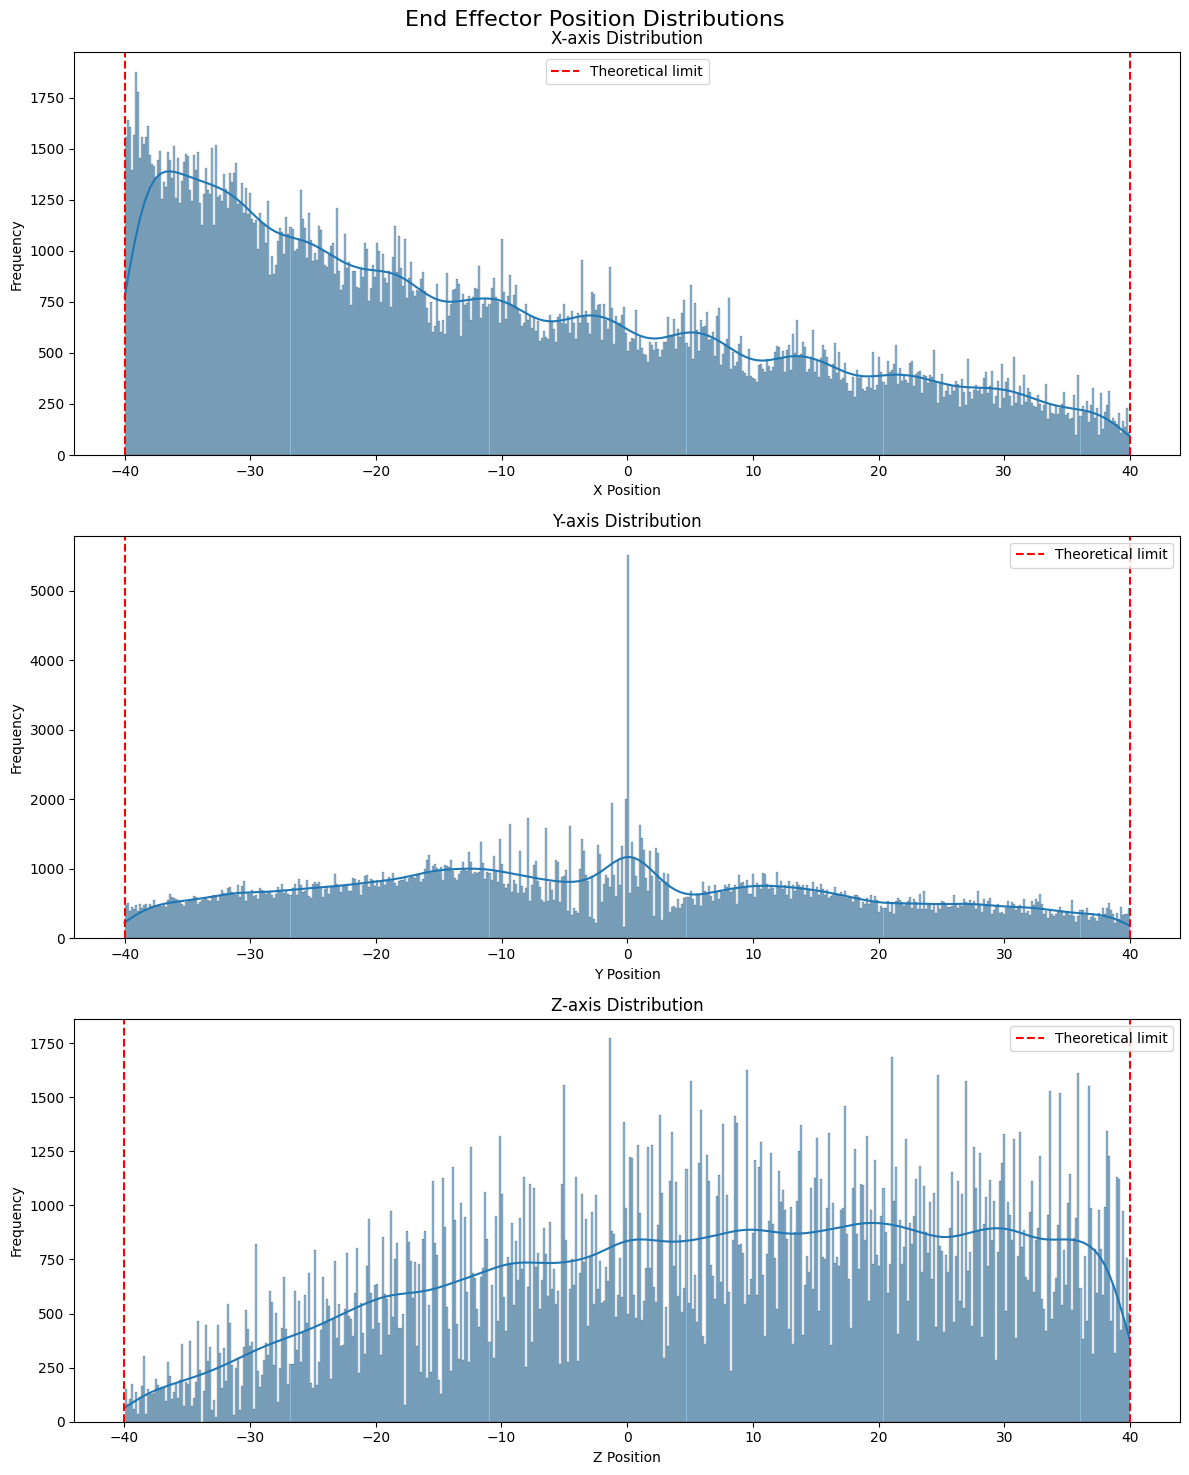

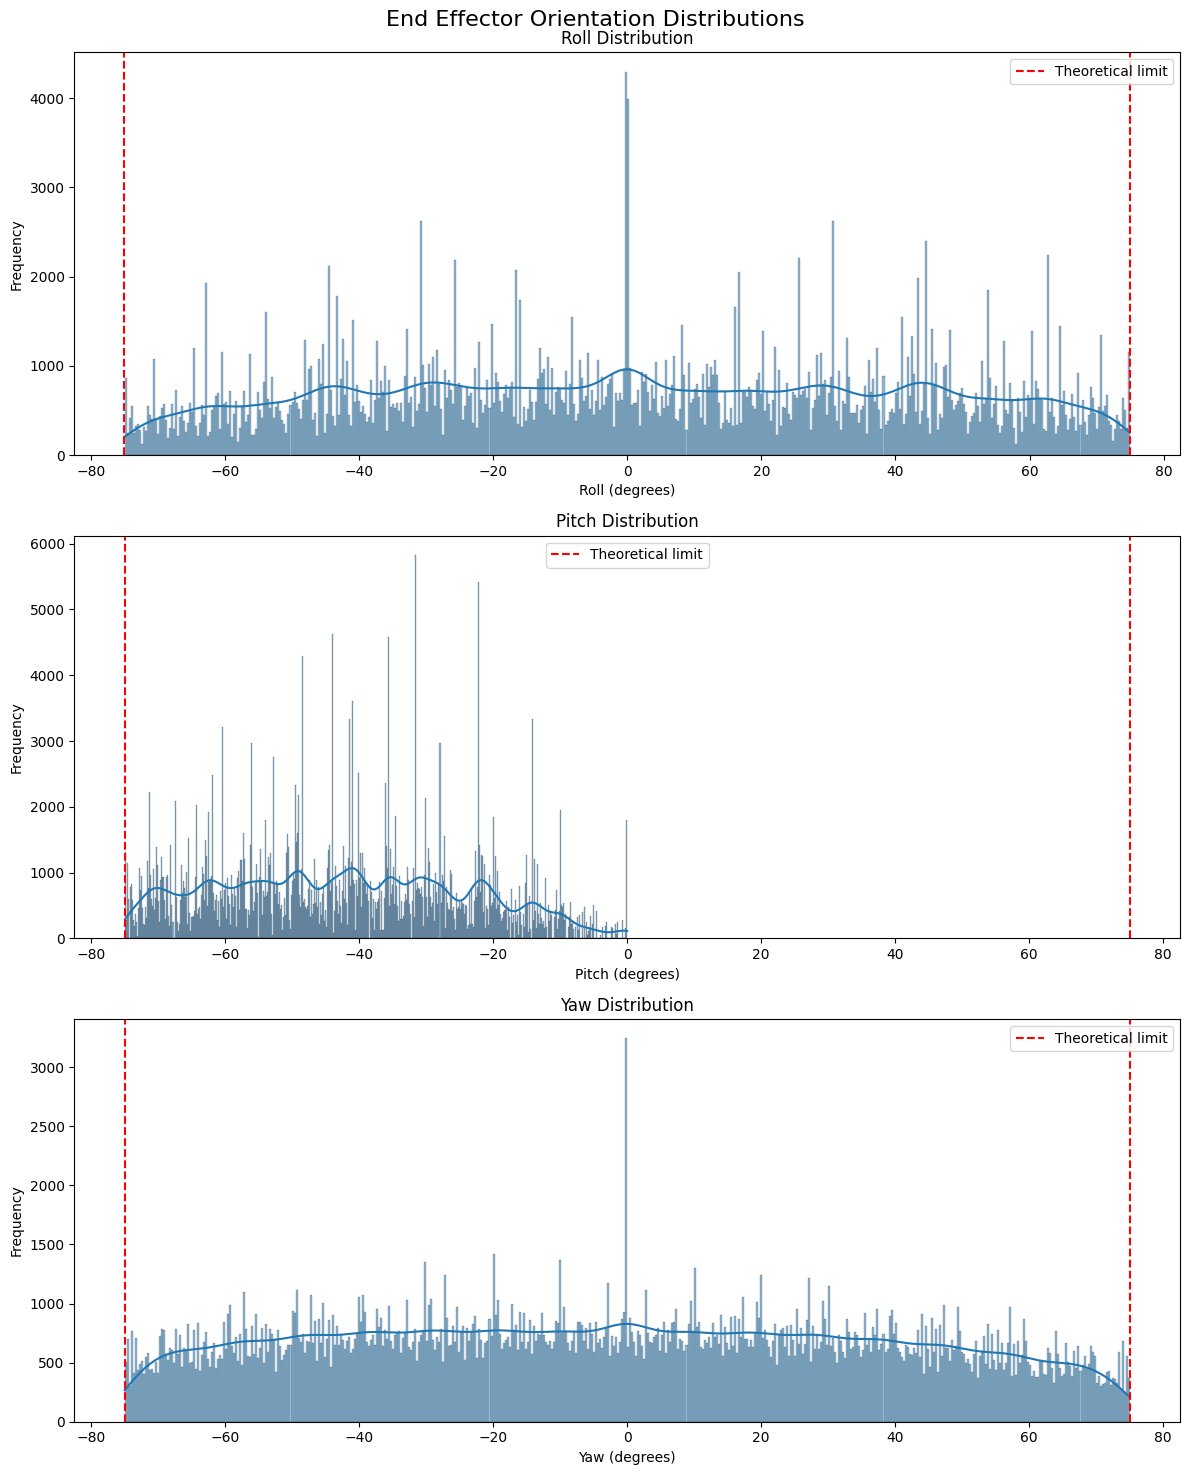

In [10]:
position_range = {'x': (-40, 40), 'y': (-40, 40), 'z': (-40, 40)}
orientation_range = {'roll': (-75, 75), 'pitch': (-75, 75), 'yaw': (-75, 75)}

plot_axis_and_orientation_distributions_kde_hist(dataset, position_range, orientation_range)

In [11]:
# If you want to see some basic statistics as well:
def print_axis_statistics(dataset):
    positions = dataset['outputs']
    for i, axis in enumerate(['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']):
        print(f"\n{axis}-axis statistics:")
        print(f"  Min: {np.min(positions[:, i]):.2f}")
        print(f"  Max: {np.max(positions[:, i]):.2f}")
        print(f"  Mean: {np.mean(positions[:, i]):.2f}")
        print(f"  Median: {np.median(positions[:, i]):.2f}")
        print(f"  Standard Deviation: {np.std(positions[:, i]):.2f}")

print_axis_statistics(dataset)


X-axis statistics:
  Min: -40.00
  Max: 40.00
  Mean: -11.61
  Median: -16.17
  Standard Deviation: 21.30

Y-axis statistics:
  Min: -40.00
  Max: 39.99
  Mean: -2.95
  Median: -3.84
  Standard Deviation: 20.39

Z-axis statistics:
  Min: -39.97
  Max: 39.97
  Mean: 6.92
  Median: 8.52
  Standard Deviation: 20.12

Roll-axis statistics:
  Min: -74.93
  Max: 74.93
  Mean: 1.14
  Median: 0.00
  Standard Deviation: 40.29

Pitch-axis statistics:
  Min: -74.90
  Max: 0.00
  Mean: -42.37
  Median: -42.46
  Standard Deviation: 18.34

Yaw-axis statistics:
  Min: -74.99
  Max: 75.00
  Mean: -2.36
  Median: -2.73
  Standard Deviation: 40.56
